In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
mc = pd.read_csv('mc.csv', index_col='eid')
data = pd.read_csv('onpeak_data.csv', index_col='eid')
offpeak = pd.read_csv('offpeak_data.csv', index_col='eid')
offpeak_weights = pd.read_csv('offpeak_weights.csv')
Dstarstar_modes = pd.read_csv('brf_others.dat')
Dstarstar_modes = Dstarstar_modes['ModeString'].values.tolist()

In [4]:
# Global variables for plotting
weight_col_names = ['weight', 'lumi_weight', 'brf_correction_weight', 'cln_weight', 'llswb1_weight', 'llswb2_weight']

# Change these if necessary:
run = 0 # = 0 for all runs
nbins_default = 'auto'
normed_flag = False
save_figures_flag = False

# Shouldn't have to change these:
golden = (1 + 5 ** 0.5) / 2
figwidth = 8
fsize = 12
color_names = [ '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#CC79A7', '#D55E00', '#0072B2' ]
alpha_val = 1.

In [5]:
def get_dstarstar_correction(row, factor):
    b1_weight = factor if row.b1_brf_mode in Dstarstar_modes else 1.
    b2_weight = factor if row.b2_brf_mode in Dstarstar_modes else 1.
    return b1_weight * b2_weight

In [6]:
mc_offpeak = mc.loc[(mc['mode_label']!=998) & (mc['mode_label']!=1005)]
offpeak = pd.merge(offpeak, offpeak_weights, on='run')

mc4_clean = mc_offpeak.copy()
mc4_clean.weight = mc4_clean.apply(lambda row: row.lumi_weight * row.brf_correction_weight *
                                               row.cln_weight  * 0.25 * 
                                               get_dstarstar_correction(row, 0.8), axis = 1)

mc5_clean = mc_offpeak.copy()
mc5_clean.weight = mc5_clean.apply(lambda row: row.lumi_weight * row.brf_correction_weight *
                                               row.cln_weight  * 0.25 * 
                                               get_dstarstar_correction(row, 0.4), axis = 1)

In [7]:
def create_hist(var_name, data_range=None, 
                nbins=nbins_default, normed_flag=False, run=run,
                legend_loc=1, log_yaxis=False, save_figures=save_figures_flag):
    if run != 0:
        mc2 = mc_offpeak.loc[mc['run']==run].loc[:,[var_name] + weight_col_names]
        mc4 = mc4_clean.loc[mc['run']==run].loc[:,[var_name] + weight_col_names]
        mc5 = mc5_clean.loc[mc['run']==run].loc[:,[var_name] + weight_col_names]
        data_var = data.loc[data['run']==run].loc[:,var_name]
        offpeak_var = offpeak.loc[offpeak['run']==run].loc[:,[var_name,'weight']]
        if data_range: # Specific run with data cuts
            mc2 = mc2.loc[(mc2[var_name] >= data_range[0]) & 
                          (mc2[var_name] <= data_range[1])]
            mc4 = mc4.loc[(mc4[var_name] >= data_range[0]) & 
                          (mc4[var_name] <= data_range[1])]
            mc5 = mc5.loc[(mc5[var_name] >= data_range[0]) & 
                          (mc5[var_name] <= data_range[1])]
            offpeak_var = offpeak_var.loc[(offpeak_var[var_name] >= data_range[0]) & 
                                          (offpeak_var[var_name] <= data_range[1])]
            data_var = [x for x in data_var if x >= data_range[0] and x <= data_range[1]]
    else:
        mc2 = mc_offpeak.loc[:,[var_name] + weight_col_names]
        mc4 = mc4_clean.loc[:,[var_name] + weight_col_names]
        mc5 = mc5_clean.loc[:,[var_name] + weight_col_names]
        data_var = data.loc[:,var_name]
        offpeak_var = offpeak.loc[:,[var_name, 'weight']]
        if data_range: # All runs with data cuts
            mc2 = mc2.loc[(mc2[var_name] >= data_range[0]) & 
                          (mc2[var_name] <= data_range[1])]
            mc4 = mc4.loc[(mc4[var_name] >= data_range[0]) & 
                          (mc4[var_name] <= data_range[1])]
            mc5 = mc5.loc[(mc5[var_name] >= data_range[0]) & 
                          (mc5[var_name] <= data_range[1])]
            offpeak_var = offpeak_var.loc[(offpeak_var[var_name] >= data_range[0]) & 
                                          (offpeak_var[var_name] <= data_range[1])]
            data_var = [x for x in data_var if x >= data_range[0] and x <= data_range[1]]
    
    # Replace cont with offpeak data
    mc2 = pd.concat([mc2, offpeak_var])
    mc2_weights = mc2.loc[:,'weight']
    mc2_var = mc2.loc[:,var_name]

    # BF/FF/D** 0.8 correction
    mc4 = pd.concat([mc4, offpeak_var])
    mc4_weights = mc4.loc[:,'weight']
    mc4_var = mc4.loc[:,var_name]
    
    # BF/FF/D** 0.4 correction
    mc5 = pd.concat([mc5, offpeak_var])
    mc5_weights = mc5.loc[:,'weight']
    mc5_var = mc5.loc[:,var_name]
    
    # Define plot and figure
    fig = plt.figure(figsize=(figwidth*golden,figwidth))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax = fig.add_subplot(gs[0])
    
    # Plot data as points with error bars; save binning information
    data_counts, bin_edges = np.histogram(data_var, nbins, normed=normed_flag)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    data_err = [x**0.5 for x in data_counts]
    ax.errorbar(bin_centers, data_counts, yerr=data_err, 
                fmt='.', mfc='black', mec='black', ecolor='black',# ms=4,
                label='Data')
    
    # Plot MC as a histogram
    mc2_counts,_,_ = ax.hist(mc2_var, normed=normed_flag, bins=bin_edges, 
                             weights=mc2_weights, label='MC with Offpeak', 
                             color=color_names[0],  edgecolor = 'white', rwidth=1.)
    mc4_counts,_,_ = ax.hist(mc4_var, normed=normed_flag, bins=bin_edges, 
                             weights=mc4_weights, label='BF/FF/D** Corrected MC 0.8', 
                             color=color_names[1],  edgecolor = 'white', rwidth=1.) 
    mc5_counts,_,_ = ax.hist(mc5_var, normed=normed_flag, bins=bin_edges, 
                             weights=mc5_weights, label='BF/FF/D** Corrected MC 0.4', 
                             color=color_names[2],  edgecolor = 'white', rwidth=1.) 
    
    # Make plot look nice
    ax.legend(prop={'size':fsize}, loc=legend_loc)
    ax.set_xlabel(var_name, fontsize=fsize)
    ax.set_ylabel('Counts', fontsize=fsize)
    ax.tick_params(length=8, width=1, labelsize=fsize)
    if log_yaxis:
        ax.set_yscale('log')
    #ax.set_xlim(plot_xrange)
    
    # Add subplot for MC-data difference
    ax2 = fig.add_subplot(gs[1])
    diff_counts = [(x-y)/float(x) for x,y in zip(data_counts, mc4_counts)]
    diff_err = [np.sqrt(y*(x+y)/x**3) for x,y in zip(data_counts, mc4_counts)]
    ax2.errorbar(bin_centers, diff_counts, color='black',
                 yerr=diff_err, fmt='.')
    
    # Make it look nice
    ax2.set_xlabel(var_name, fontsize=fsize)
    ax2.set_ylabel('Data - MC(0.8) / Data', fontsize=fsize)
    ax2.tick_params(length=8, width=1, labelsize=fsize-1)
    ax2.axhline(0, color='black')
    ax2.set_xlim(ax.get_xlim())
    ymin, ymax = ax2.get_ylim()
    ymin, ymax = -1.*max([abs(ymin), abs(ymax)]), max([abs(ymin), abs(ymax)])
    #ax2.set_ylim([ymin, ymax])
    ax2.set_ylim([-0.5, 0.5])
    
    if save_figures_flag:
        fig.savefig('{0}.pdf'.format(var_name), bbox_inches='tight')
    
    return fig

_ = create_hist('signal_score', data_range=[0,0.1], nbins=70)

_ = create_hist('dstartau_score', data_range=[0.2,0.7])

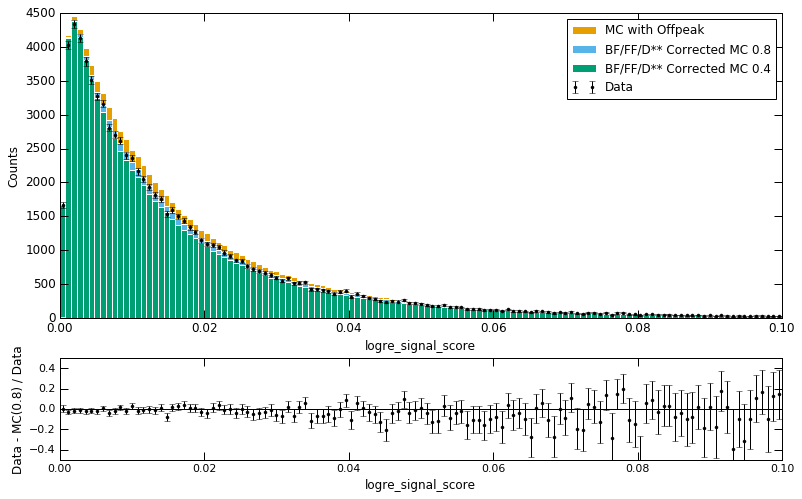

In [8]:
_ = create_hist('logre_signal_score', data_range=[0,0.1])

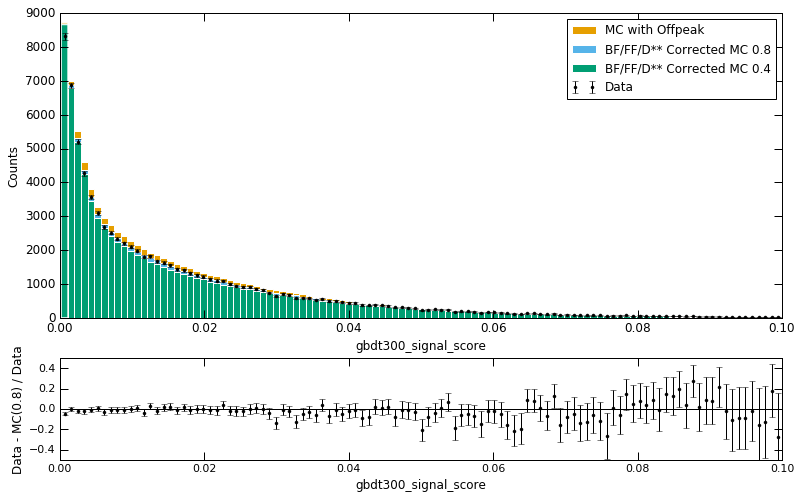

In [9]:
_=create_hist('gbdt300_signal_score', data_range=[0,0.1])

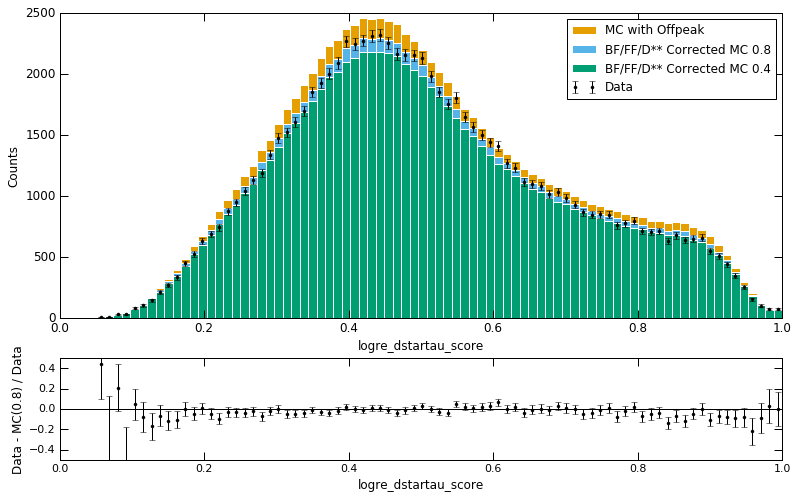

In [10]:
_=create_hist('logre_dstartau_score')

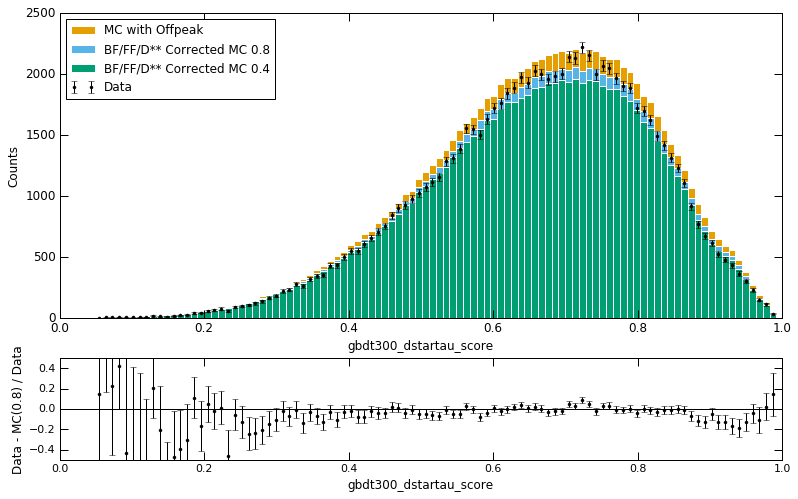

In [11]:
_=create_hist('gbdt300_dstartau_score', legend_loc=2)

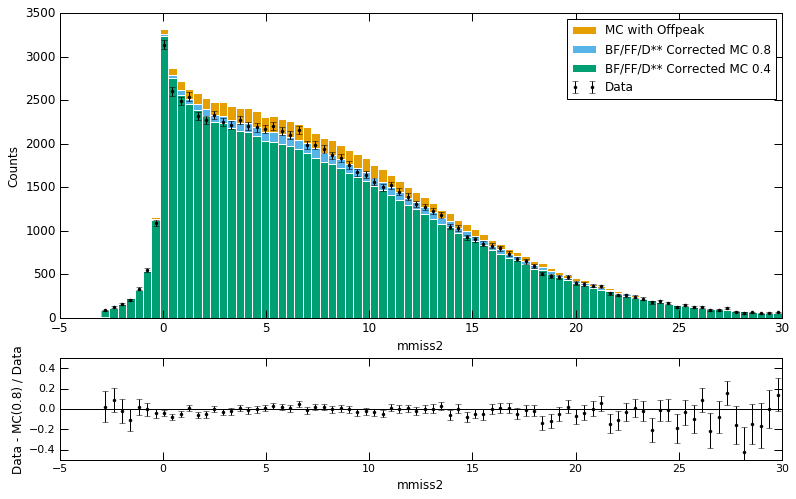

In [12]:
_ = create_hist('mmiss2', data_range=[-3,30])

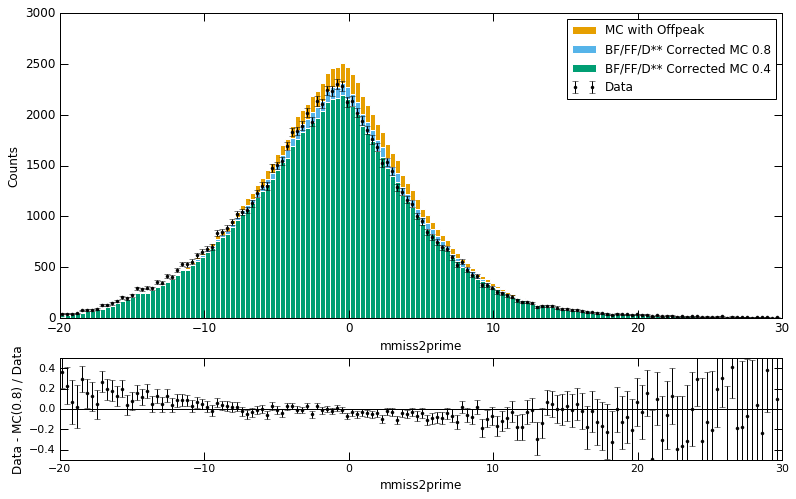

In [13]:
_ = create_hist('mmiss2prime', data_range=[-20,30])

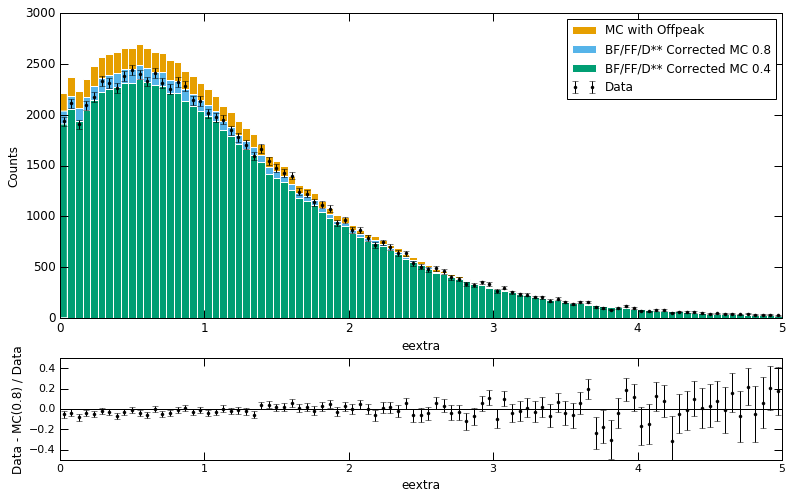

In [14]:
_ = create_hist('eextra', data_range=[0,5])

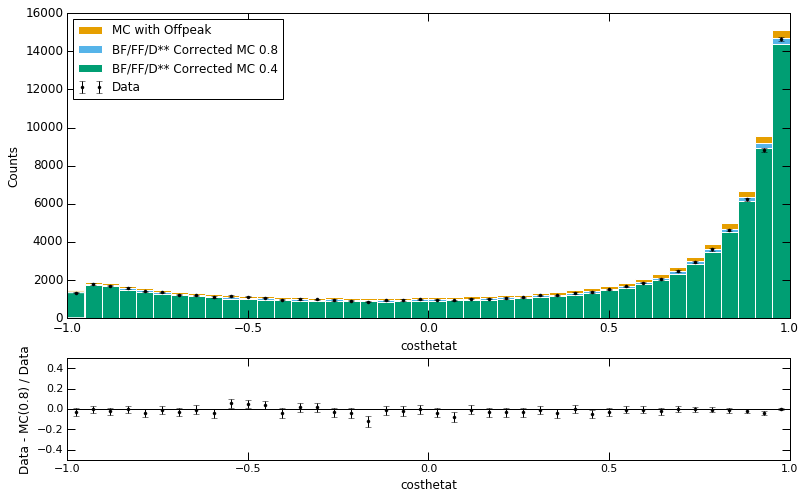

In [15]:
_ = create_hist('costhetat', legend_loc=2)

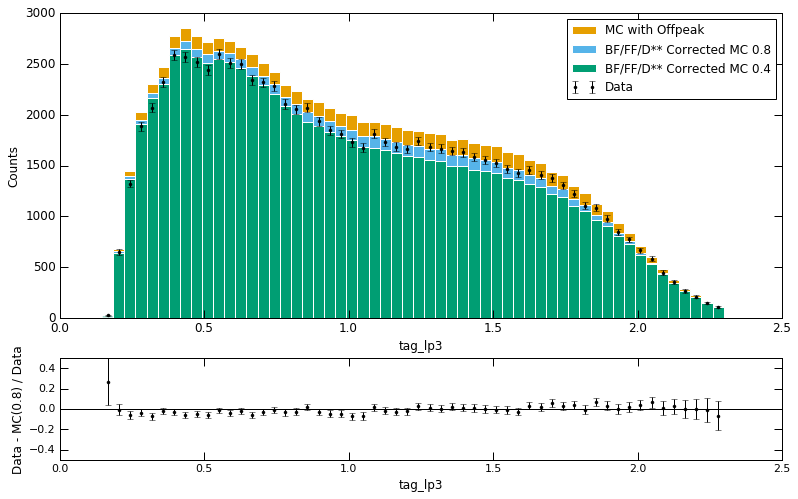

In [16]:
_ = create_hist('tag_lp3', data_range=[0,2.3])

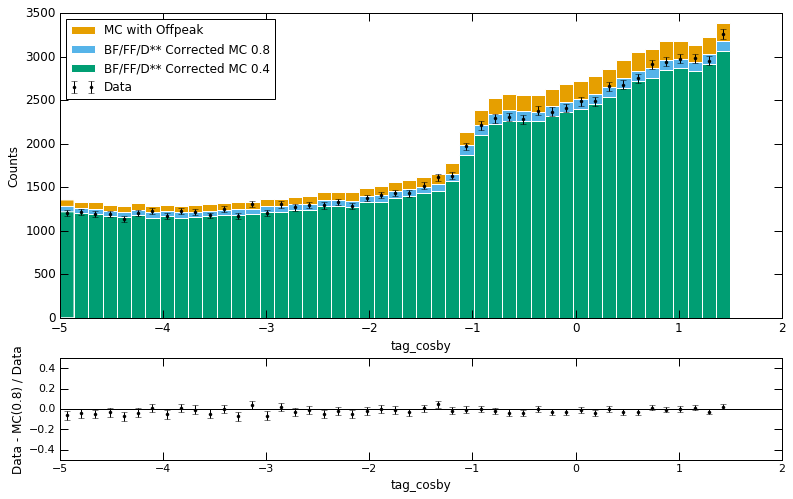

In [17]:
_ = create_hist('tag_cosby', legend_loc=2)

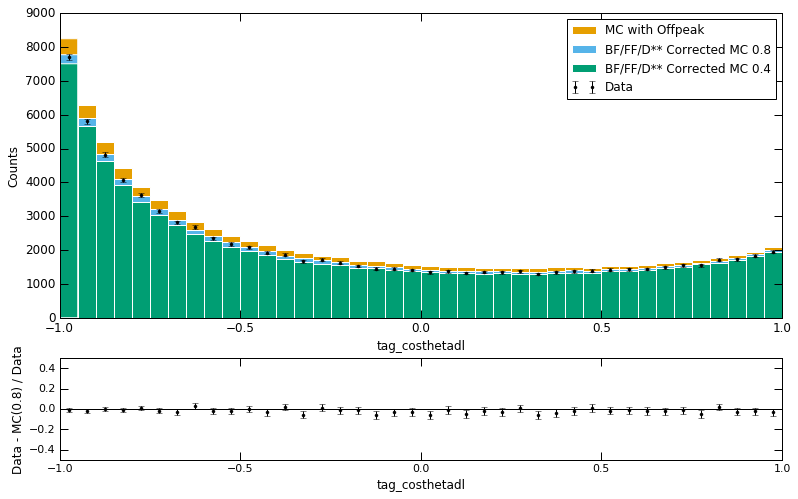

In [18]:
_ = create_hist('tag_costhetadl')

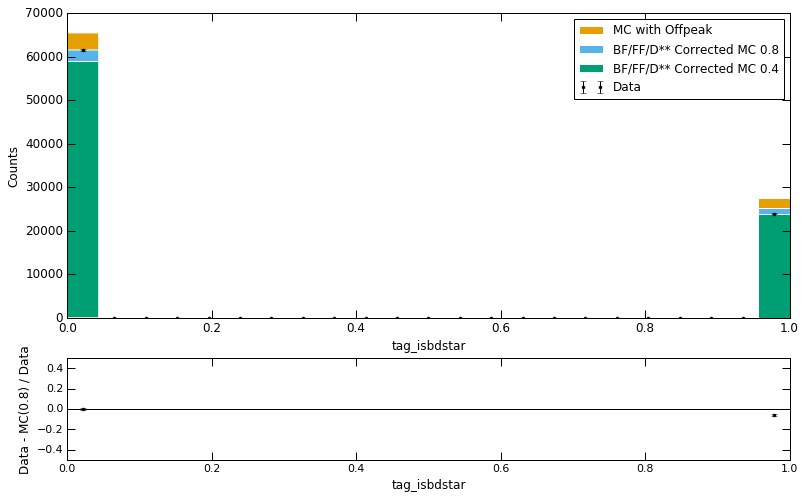

In [19]:
_ = create_hist('tag_isbdstar')

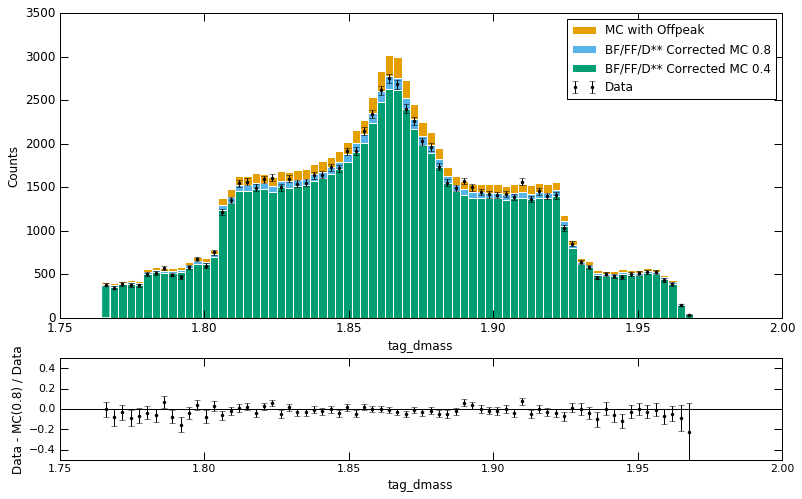

In [20]:
_ = create_hist('tag_dmass')

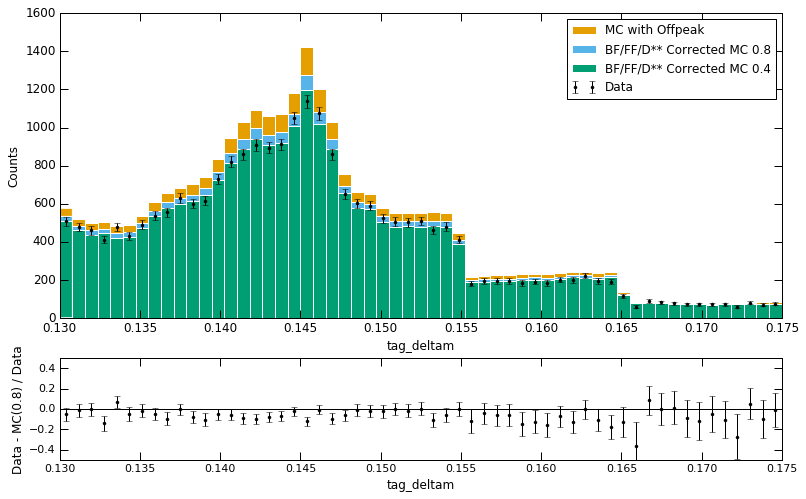

In [21]:
_ = create_hist('tag_deltam', data_range=[0,2])

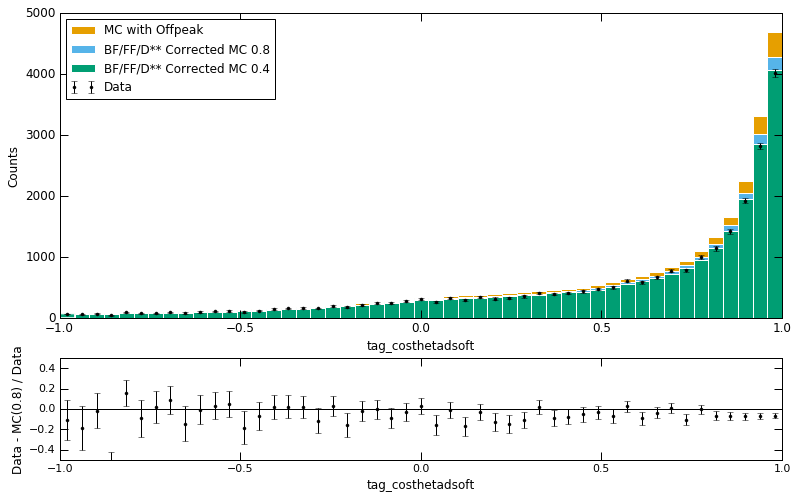

In [22]:
_ = create_hist('tag_costhetadsoft', data_range=[-1.1, 1.1], legend_loc=2)

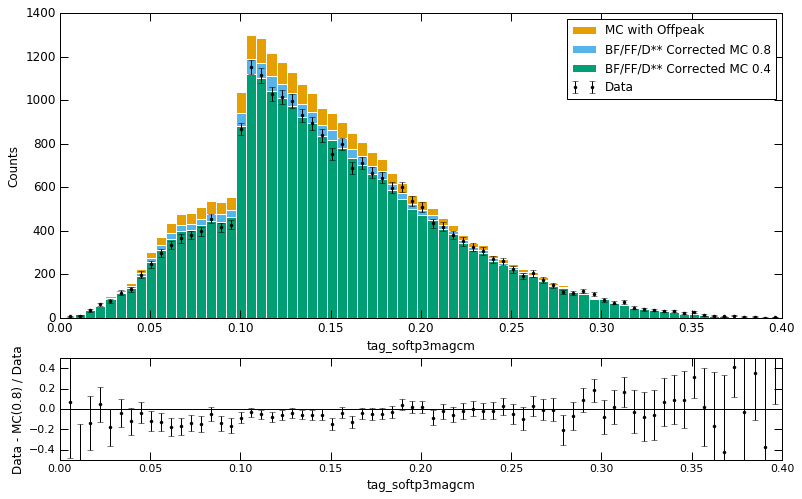

In [23]:
_ = create_hist('tag_softp3magcm', data_range=[-0.1, 1])

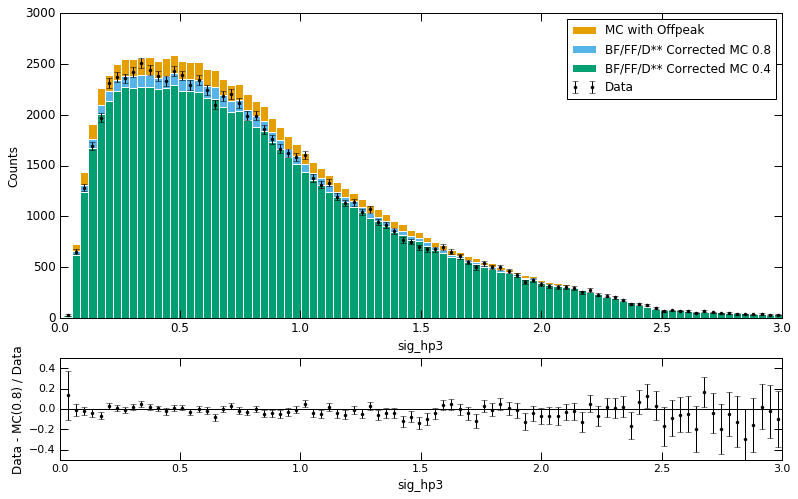

In [24]:
_ = create_hist('sig_hp3', data_range=[0,3])

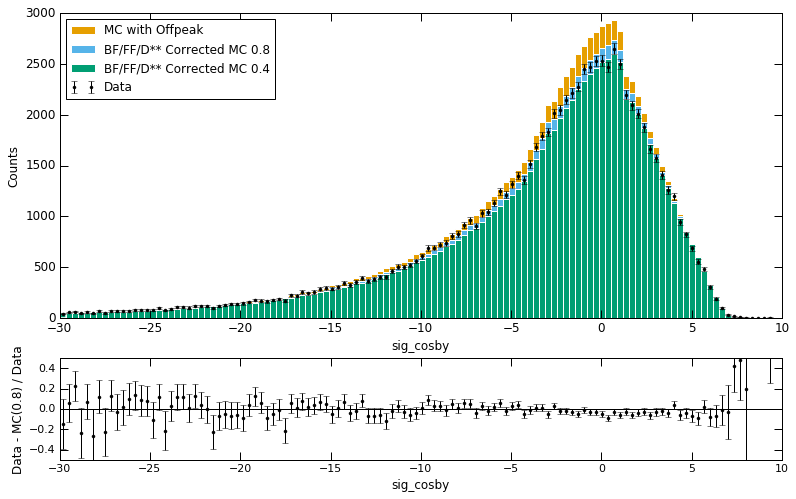

In [25]:
_ = create_hist('sig_cosby', data_range=[-30,50], legend_loc=2)

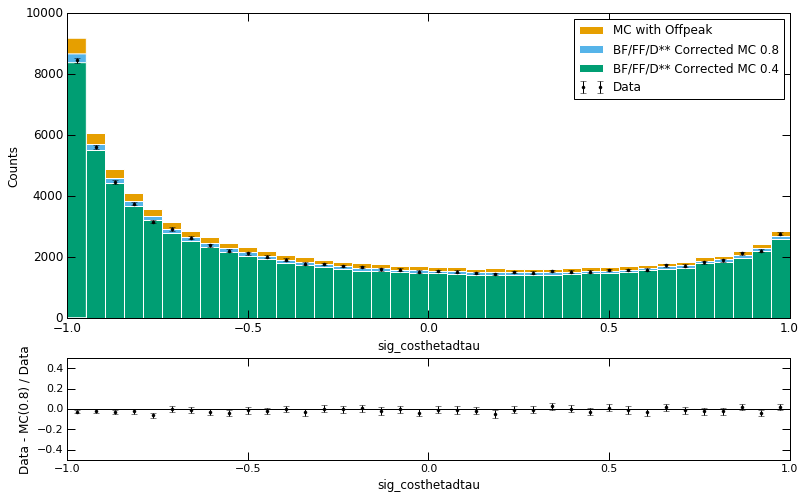

In [26]:
_ = create_hist('sig_costhetadtau')

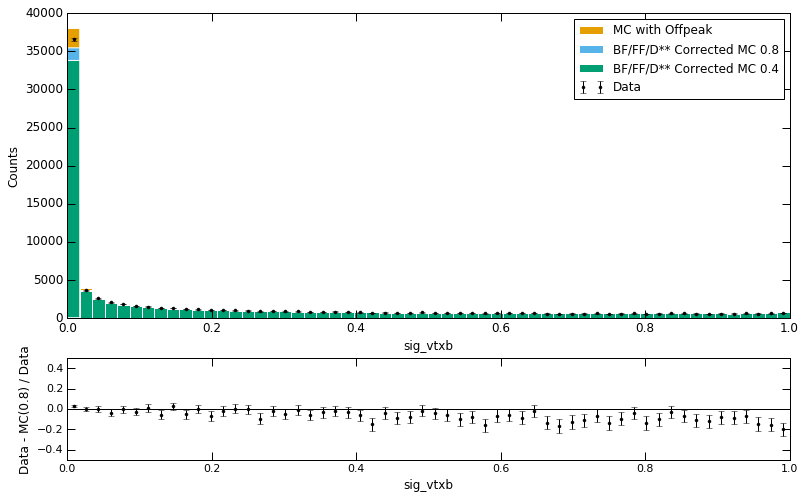

In [27]:
_ = create_hist('sig_vtxb')

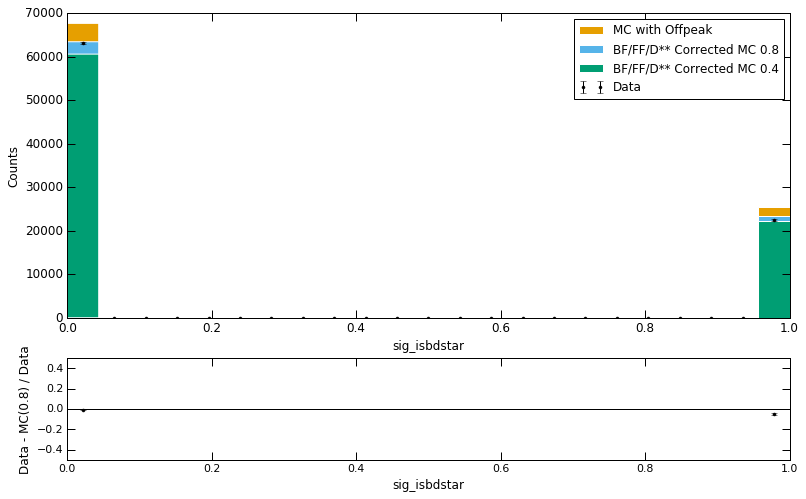

In [28]:
_ = create_hist('sig_isbdstar')

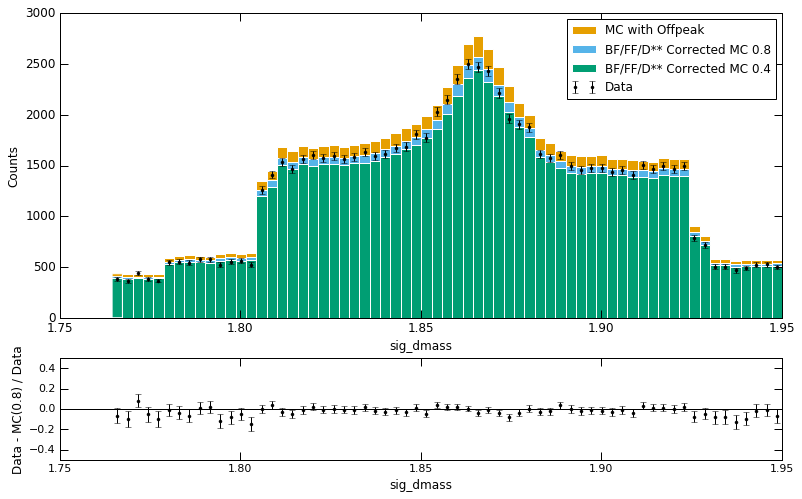

In [29]:
_ = create_hist('sig_dmass', data_range=[1.5,1.95])

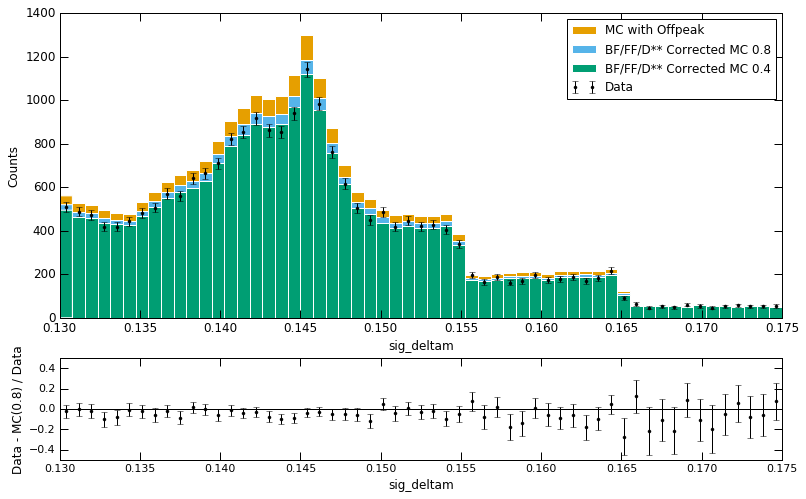

In [30]:
_ = create_hist('sig_deltam', data_range=[0, 1])

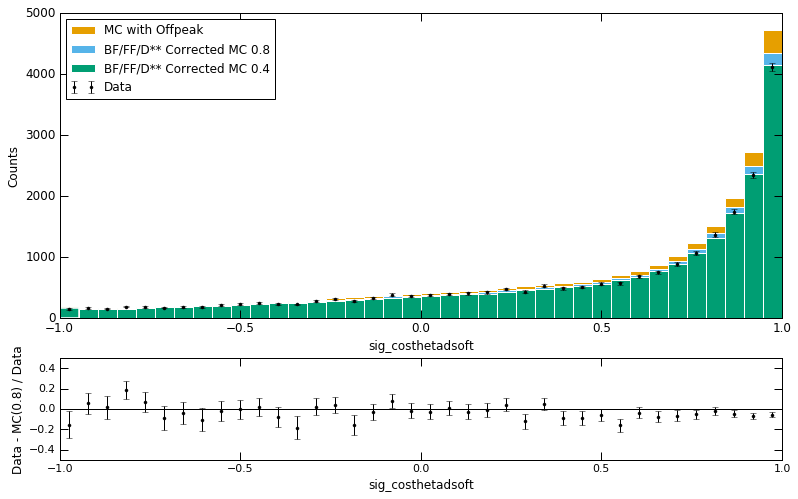

In [31]:
_ = create_hist('sig_costhetadsoft', data_range=[-1.1, 1], legend_loc=2)

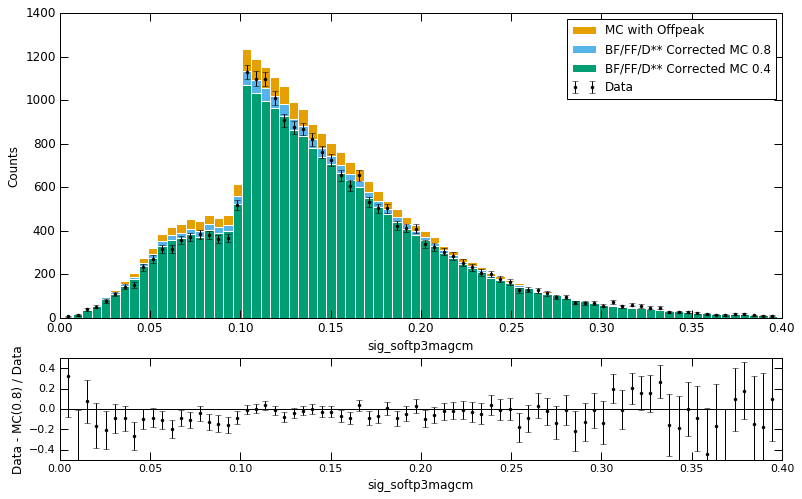

In [32]:
_ = create_hist('sig_softp3magcm', data_range=[-0.5,1])

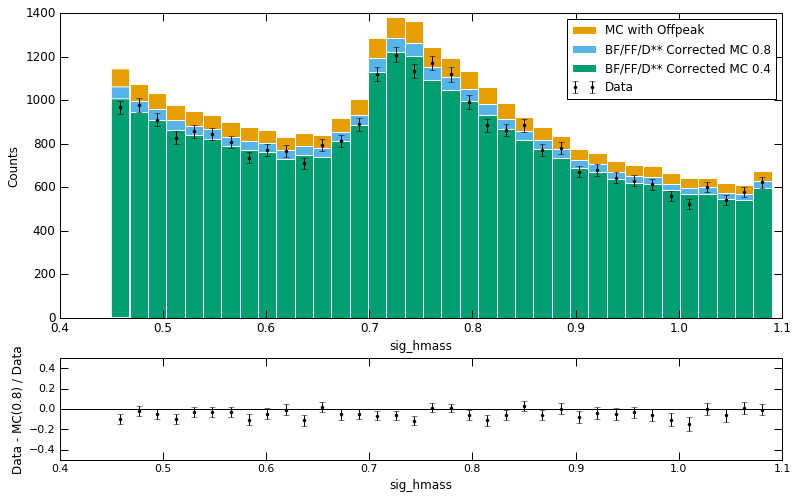

In [33]:
_ = create_hist('sig_hmass', data_range=[0,2])

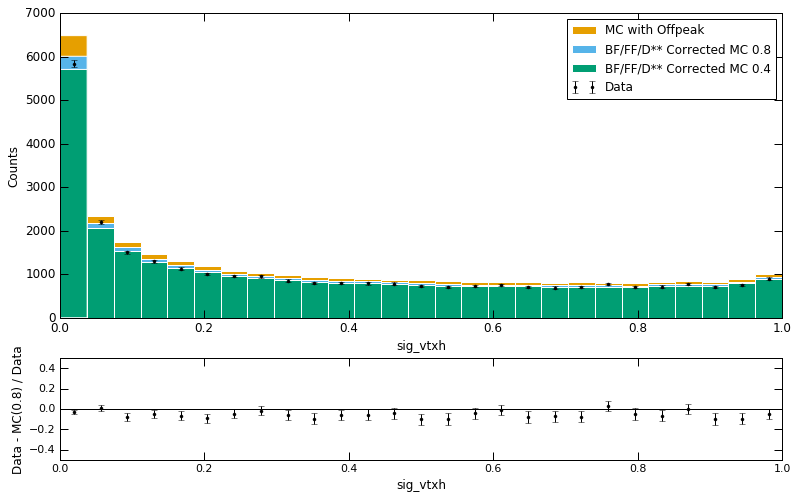

In [34]:
_ = create_hist('sig_vtxh', data_range=[-0.5,2])

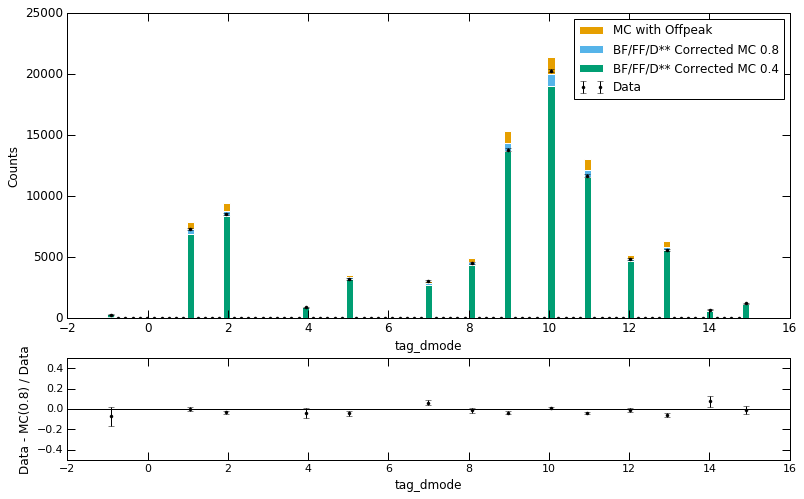

In [35]:
_ = create_hist('tag_dmode')

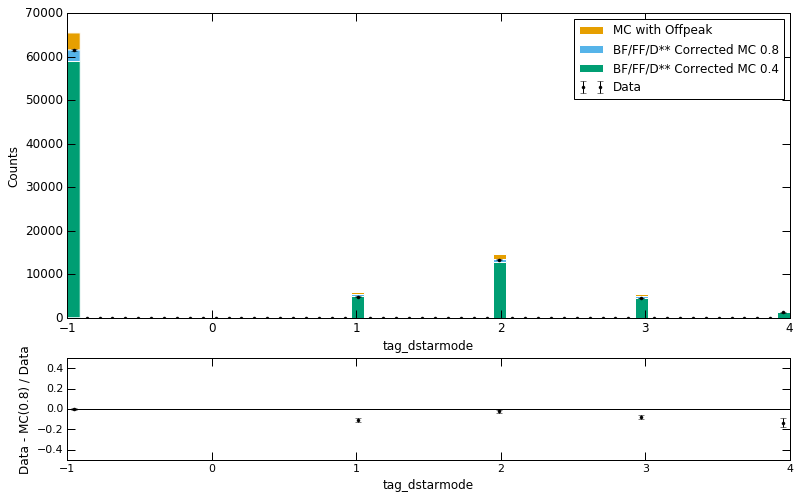

In [36]:
_ = create_hist('tag_dstarmode')

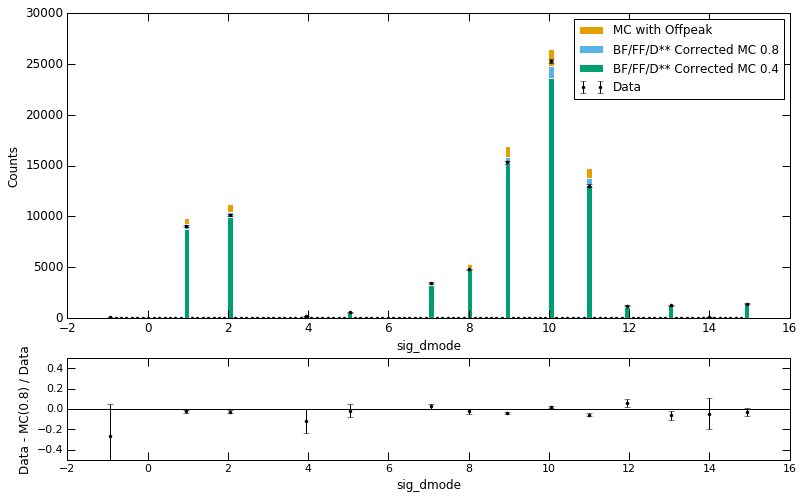

In [37]:
_ = create_hist('sig_dmode')

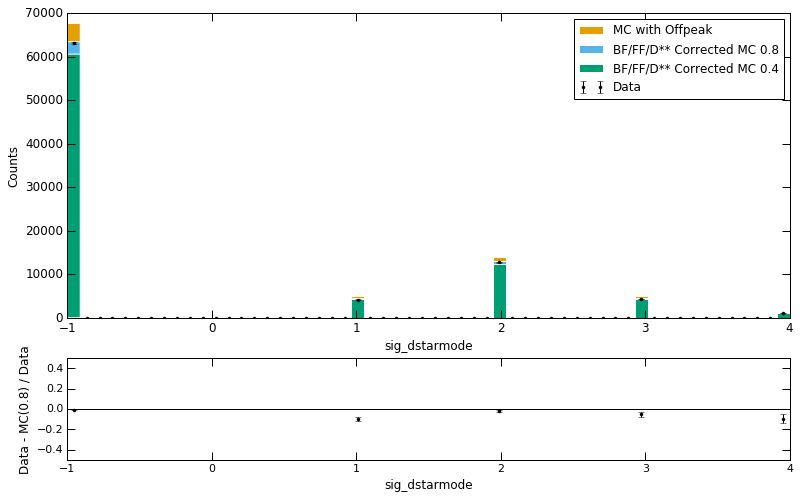

In [38]:
_ = create_hist('sig_dstarmode')

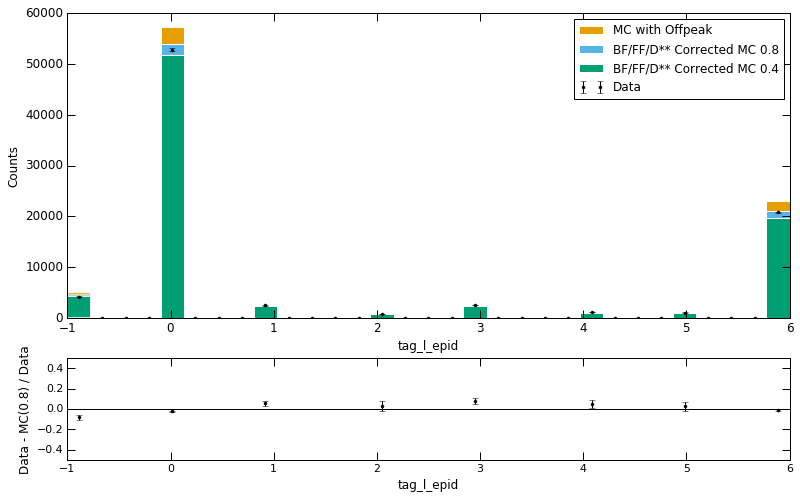

In [39]:
_ = create_hist('tag_l_epid')

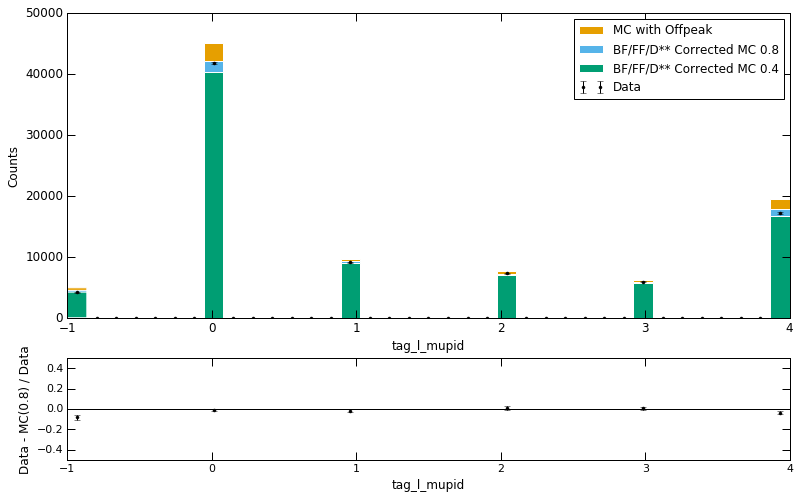

In [40]:
_ = create_hist('tag_l_mupid')

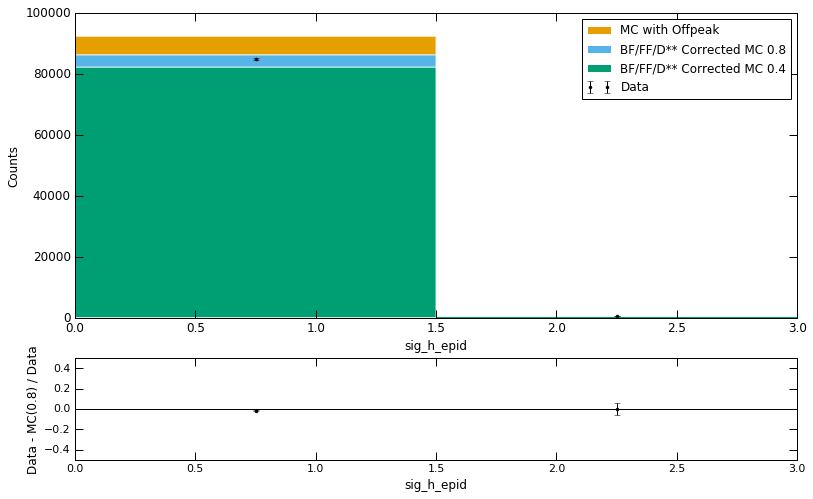

In [41]:
_ = create_hist('sig_h_epid', nbins=2)

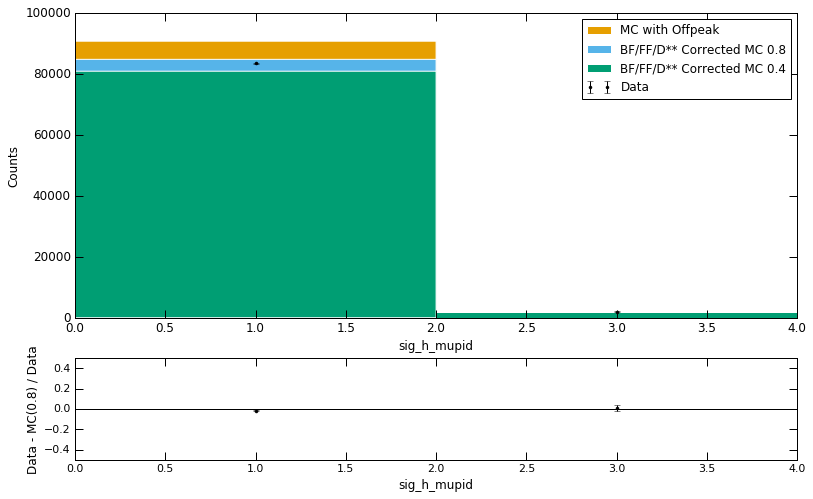

In [42]:
_ = create_hist('sig_h_mupid', nbins=2)

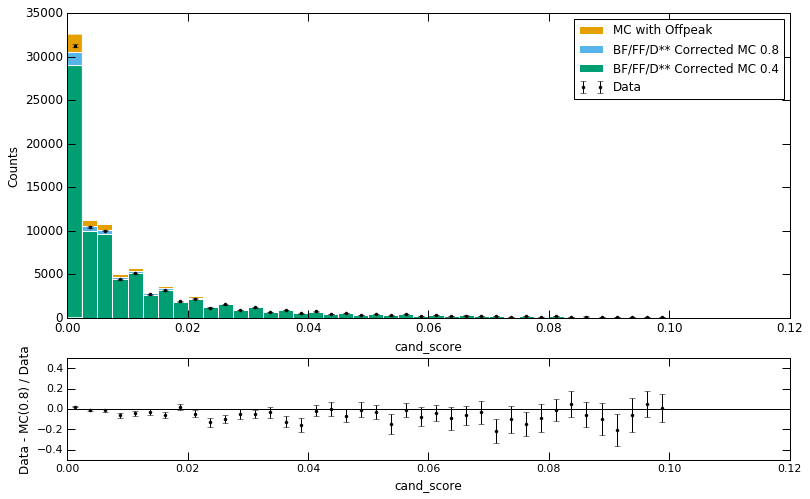

In [43]:
_ = create_hist('cand_score', data_range=[0,0.1], nbins=40)

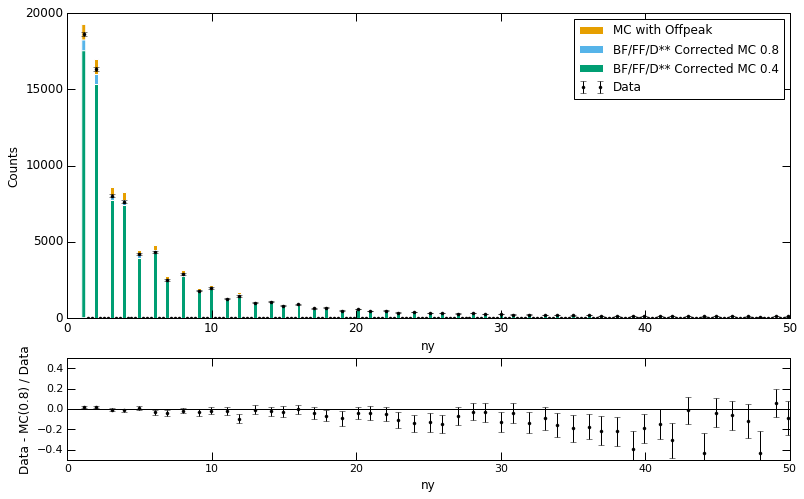

In [44]:
_ = create_hist('ny', data_range=[0,50])

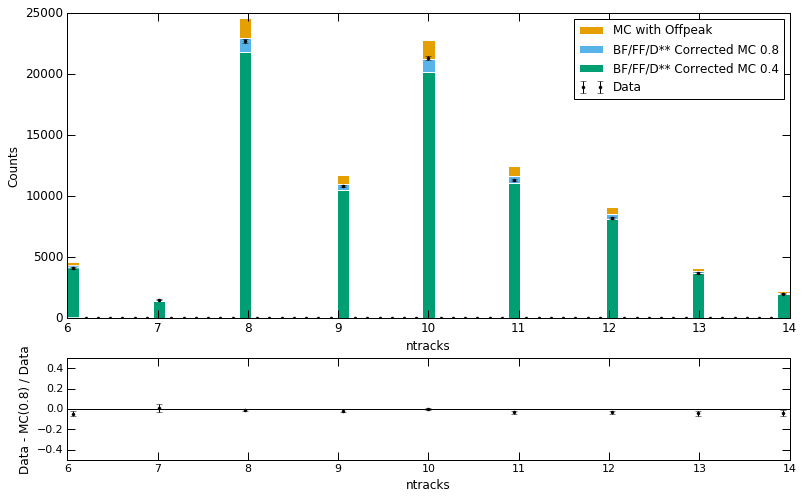

In [45]:
_ = create_hist('ntracks')

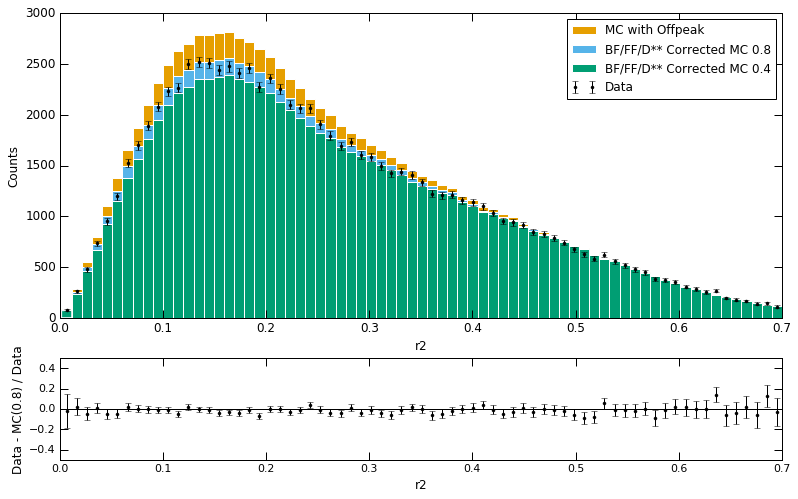

In [46]:
_ = create_hist('r2', data_range=[0,0.7])

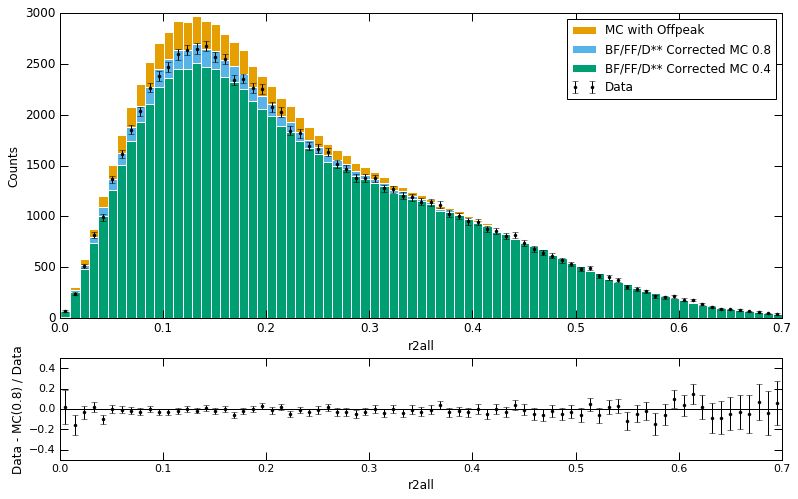

In [47]:
_ = create_hist('r2all', data_range=[0,0.7])